# PySCNet: A tool for reconstructing and analyzing gene regulatory network from single-cell RNA-Seq data

PySCNet includes four modules:

1) **Pro-precessing**: initialize a gnetData object consisting of Expression Matrix, Cell Attributes, Gene Attributes and Network Attributes; <br/>
2) **BuildNet**: reconstruct GRNs by various methods implemented in docker;<br/>
3) **NetEnrich**: network analysis including consensus network detection, gene module identification and trigger path prediction as well as network fusion;<br/>
4) **Visulization**: network illustration.<br/>

A python package - [STREAM](https://github.com/pinellolab/STREAM) was designed for reconstructing cell trajectory for single cell transcriptomic data. This tutorial guides how to integrate STREAM with pyscnet for gene regulatory network along the cell differential trajectory.


In [1]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=60, facecolor='white')

from pyvis.network import Network
import pandas as pd
import copy
import numpy as np
from pyscnet.Preprocessing import gnetdata
from pyscnet.BuildNet import gne_dockercaller as gdocker
from pyscnet.NetEnrich import graph_toolkit as gt
from pyscnet.Plotting import show_net as sn
from pyscnet.Plotting import geneHeatmap as gh

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.17.5 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1


### Data resource
Data was obtained from [Nestorowa, S. et al](https://doi.org/10.1182/blood-2016-05-716480). The cell trajectory was build according to [STREAM Tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true). As STREAM is also built on AnnData structure, it can be directly imported into pyscnet.

In [2]:
#the file is too large
# import _pickle as pk
# with open('data/stream_adata.pk', 'rb') as input:
#     adata = pk.load(input)

import stream as st
adata = st.read('data/stream_adata.pklz')

Working directory is already specified as './result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


As explained in [STREAM Tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true), new attributes including cell pseudotime at different branches are added into **obs** of AnnData. It gives us the hints of ordering cells by pseudotime and estimating gene dynamics along cell trajectory.

In [3]:
adata

AnnData object with n_obs × n_vars = 1656 × 35077
    obs: 'label', 'label_color', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S1_pseudotime', 'S2_pseudotime'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'workdir', 'label_color', 'assay', 'var_genes', 'trans_se', 'params', 'epg', 'flat_tree', 'seed_epg', 'seed_flat_tree', 'ori_epg', 'epg_obj', 'ori_epg_obj', 'branch_id_alias_color', 'stream_S2', 'scaled_marker_expr', 'leaf_markers_all', 'leaf_markers', 'stream_S3', 'transition_markers', 'de_markers_greater', 'de_markers_less', 'markers_label_all', 'markers_label'
    obsm: 'var_genes', 'X_se', 'X_dr', 'X_spring', 'X_stream_S2', 'X_stream_S3'

### Cell trajectories built by stream
As shown below, 6 cell sub-populations form a Bifurcation trajectory starting from HSC expanding into two directions. One is MEP branch and the other one is GMP branch. Additionally, leaf markers and transition markers are detected for each branch. It guides us for feature selection

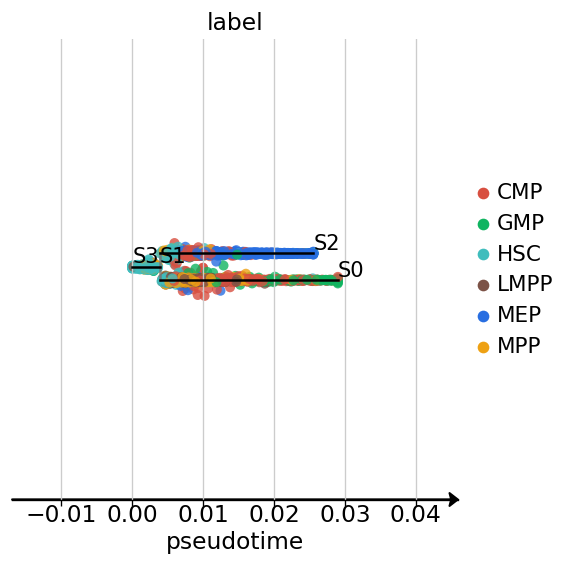

In [4]:
st.plot_stream_sc(adata,root='S3',color=['label'], fig_size=[5, 5],
                  dist_scale=0.3,show_graph=True,show_text=True)

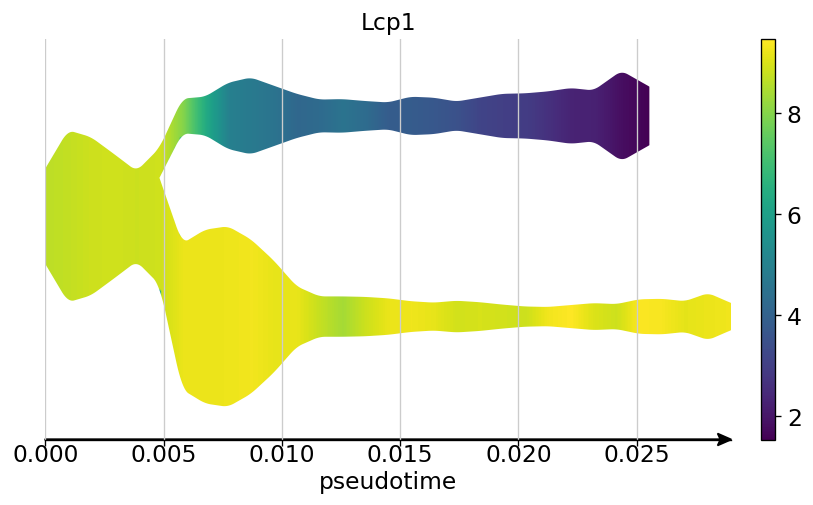

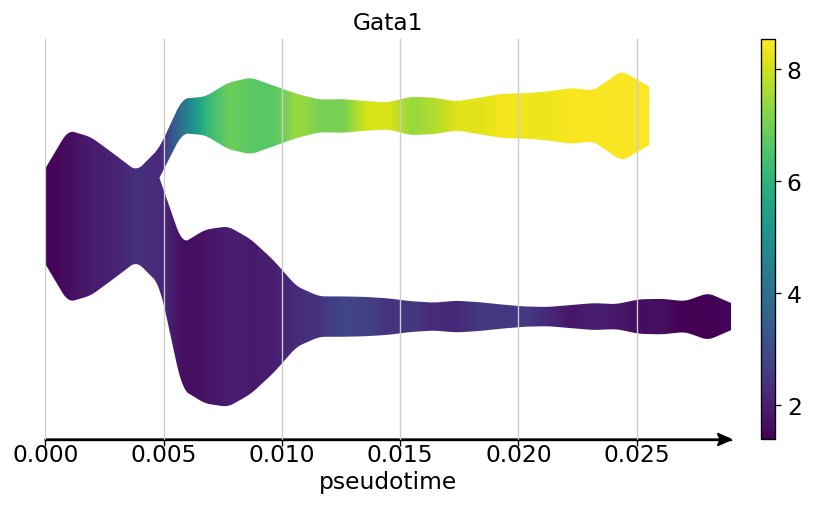

In [5]:
#leaf_markers of cell pathway: S1 -> S2
# adata.uns['leaf_markers'][('S1','S2')].head()
st.plot_stream(adata,root='S3',color=['Lcp1', 'Gata1'])

In [6]:
# transition markers of cell path: S1 -> S2
# adata.uns['transition_markers'][('S1', 'S2')].head()
# st.plot_stream(adata,root='S3',color=['Blvrb', 'Tmsb4x'])

In [7]:
#Import stream anndata into pyscnet
stream_gne = gnetdata.load_from_scanpy(adata)

### Select trajectory branch and Features for GRN
In the following, cells from **S1** to **S2** and **positive leaf markers** of (S1->S2) will be selected for GRN construction. As shown below, positive leaf markers are only highly expressed in cells of S1 -> S2. There are 236 genes and 535 cells selected for downstream analysis. 

In [8]:
#select cells from S1 -> S2
cell_info = stream_gne.CellAttrs['CellInfo']
cell = list(cell_info.loc[cell_info['branch_id_alias'].isin([('S2', 'S1')])].index)
len(cell)

535

In [9]:
#select positive leaf markers 
feature = adata.uns['leaf_markers'][('S1', 'S2')]
feature = list(feature.loc[feature.zscore > 0].index)
len(feature)

236

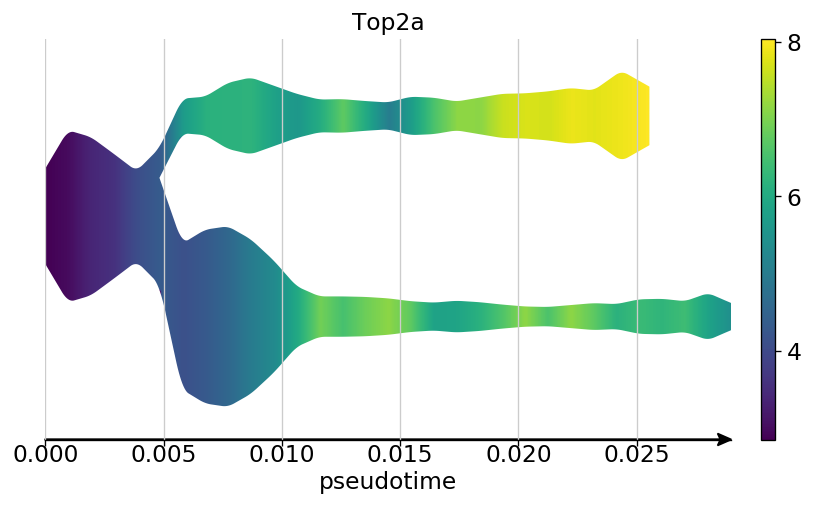

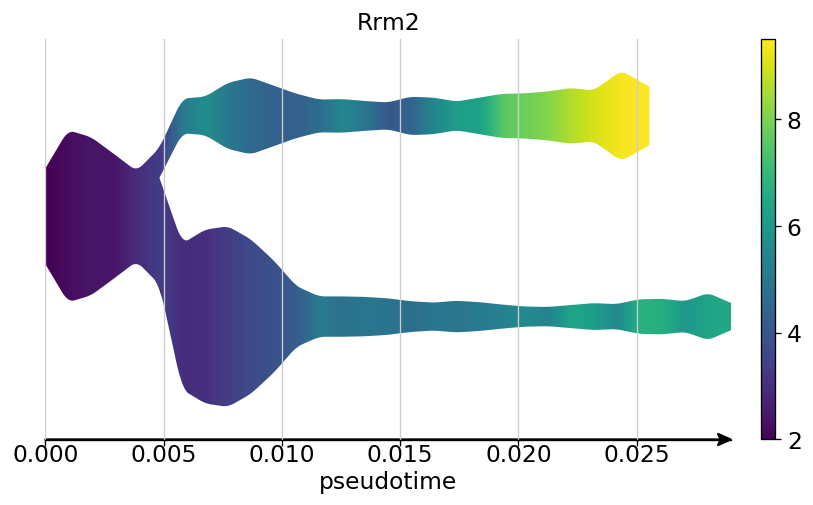

In [10]:
st.plot_stream(adata,root='S3',color=['Top2a', 'Rrm2'])

### BuildNet: Construct GRN by applying popular methods 
As reported in [GRN benchmark paper](https://pubmed.ncbi.nlm.nih.gov/31907445/), although some tools were designed for estimating gene regulatory relationship from transcriptomic data, only three methods ([GENIE3](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), [PIDC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624513/) and [GRNBOOST2](https://academic.oup.com/bioinformatics/article-abstract/35/12/2159/5184284?redirectedFrom=fulltext)) were considered as competitive. However, results generated from different algorithms based on different assumptions are inconsistent. Therefore, defining a consensus network from multiple network becomes essential for the downstream analysis.

In [11]:
stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='GENIE3', 
                               feature=feature, cell_clusterid=('S2', 'S1'), select_by='branch_id_alias')

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='PIDC', 
                               feature=feature, cell_clusterid=('S2', 'S1'), select_by='branch_id_alias')

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='CORR', 
                               feature=feature, cell_clusterid=('S2', 'S1'), select_by='branch_id_alias')

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='GRNBOOST2', 
                               feature=feature, cell_clusterid=('S2', 'S1'), select_by='branch_id_alias')

GENIE3_links added into NetAttrs
PIDC_links added into NetAttrs
CORR_links added into NetAttrs
GRNBOOST2_links added into NetAttrs


In [12]:
list(filter(lambda x:'links' in x, stream_gne.NetAttrs.keys()))

['GENIE3_links', 'PIDC_links', 'CORR_links', 'GRNBOOST2_links']

### NetEnrich: Consensus edges and Build graph
pyscnet provides multiple ways of predicting consensus network: 

1) random forest classification; <br/>
2) network intersection; <br/>

Given consensus prediction, top *k* edges are selected for building gene graph. Genes importance can be estimated via node centralities including **Degree, PageRank, Closeness**. Furthermore, gene modules are predicted by applying community detection algorithms.

In [13]:
#find consensus links based on ensemble classification
stream_gne = gt.find_consensus_graph(stream_gne, method='ensemble', threshold=3)

#build graph for consensus links
stream_gne = gt.buildnet(stream_gne, key_links='consensus')

there are 304 consensus edges found!
graph added into NetAttrs


In [14]:
stream_gne.NetAttrs['consensus'].head()

,source,target,weight
249,Aqp1,Creg1,1.0
88,Dut,Mcm7,1.0
50,Mfsd2b,Slc14a1,1.0
372,Ces2g,Prdx6,1.0
12,Tmem14c,Fam132a,1.0


In [15]:
#calculate node centrality
stream_gne = gt.get_centrality(stream_gne)

#detect gene community
stream_gne = gt.detect_community(stream_gne)


node centralities added into NetAttrs.
gene communities added into NetAttrs


### NetEnrich: Graph travel and supervised random walk
NetEnrich module integretes graph traversal techniques to expolre gene regulatory network. It includes **Breadth-first search**, **Depth-first search** and **Supervised random walk**. In this way, gene trigger paths indicating genes with hidden associations can be predicted. 

In [16]:
# Breadth-first search to explore gene network
bfs_path = list(gt.graph_traveral(stream_gne.NetAttrs['graph'], start='Top2a', threshold=3, method='bfs'))
# bfs_path

#Supervised random walk
random_path = gt.random_walk(stream_gne, start = 'Top2a', supervisedby='degree', steps=5)
random_path

['Top2a', 'Rrm2', 'Dut', 'Uhrf1', 'Mcm3', 'Mcm5']

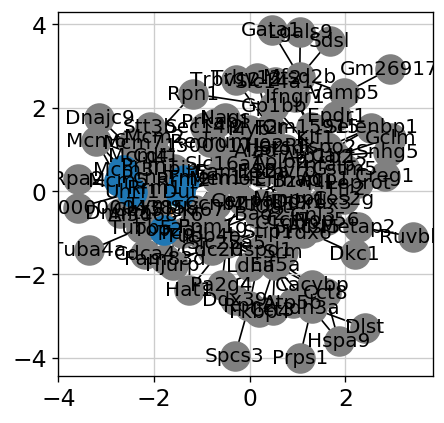

In [17]:
# #present network with random path highlighted
sn.static_netShow(stream_gne, filename ='result/stream_gne_consensus.pdf', figure_size=[50, 50],
                  random_path=random_path, link_key='consensus', path_highlight=True)

### Plotting: Network Visualization 
Plotting module principlely provides a set of functions for visualization.

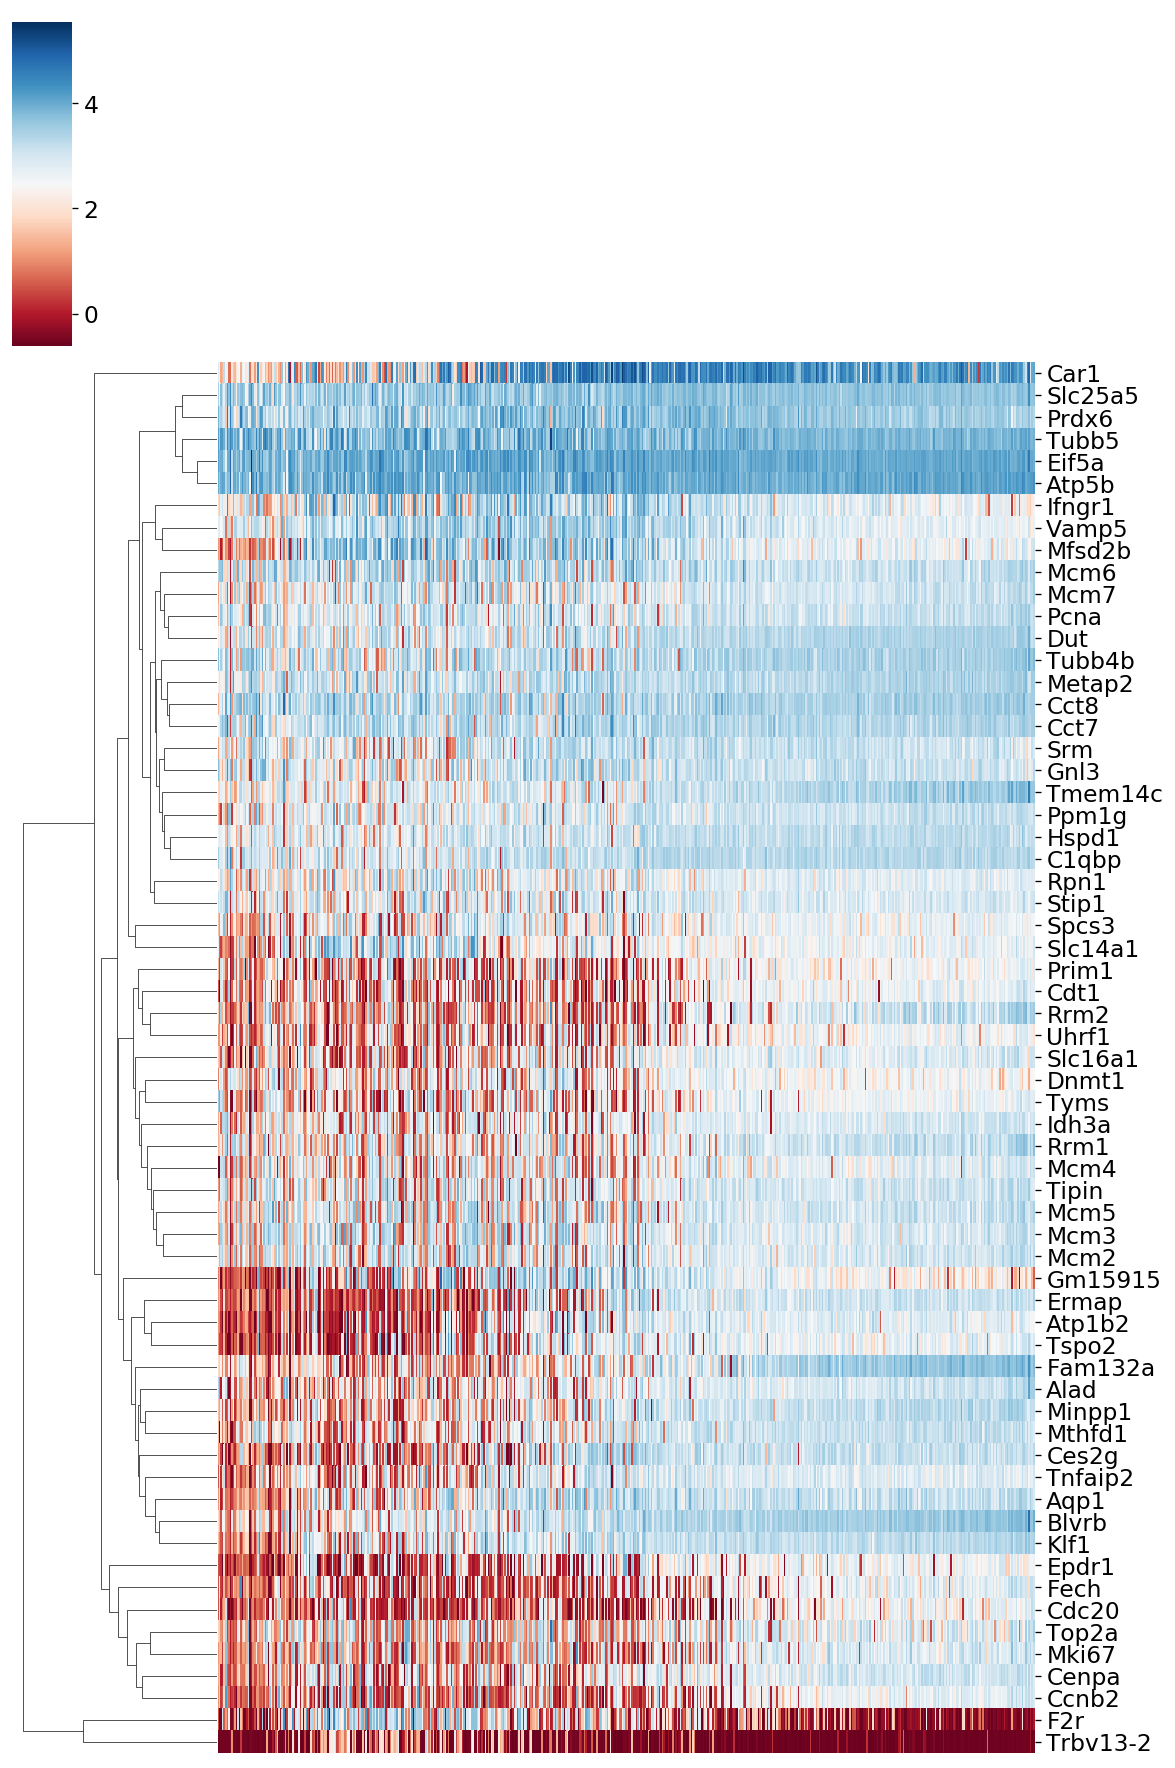

In [18]:
#check gene expression in the indivisual cells along the pseudotime
gh.geneHeatmap(stream_gne, gene=set(stream_gne.NetAttrs['consensus'].source),
            cell_clusterid=('S2', 'S1'), select_by='branch_id_alias',
            order_by='S1_pseudotime', col_cluster=False, yticklabels=True, 
            figsize=[10,15], save_as='result/gene_heatmap.pdf')

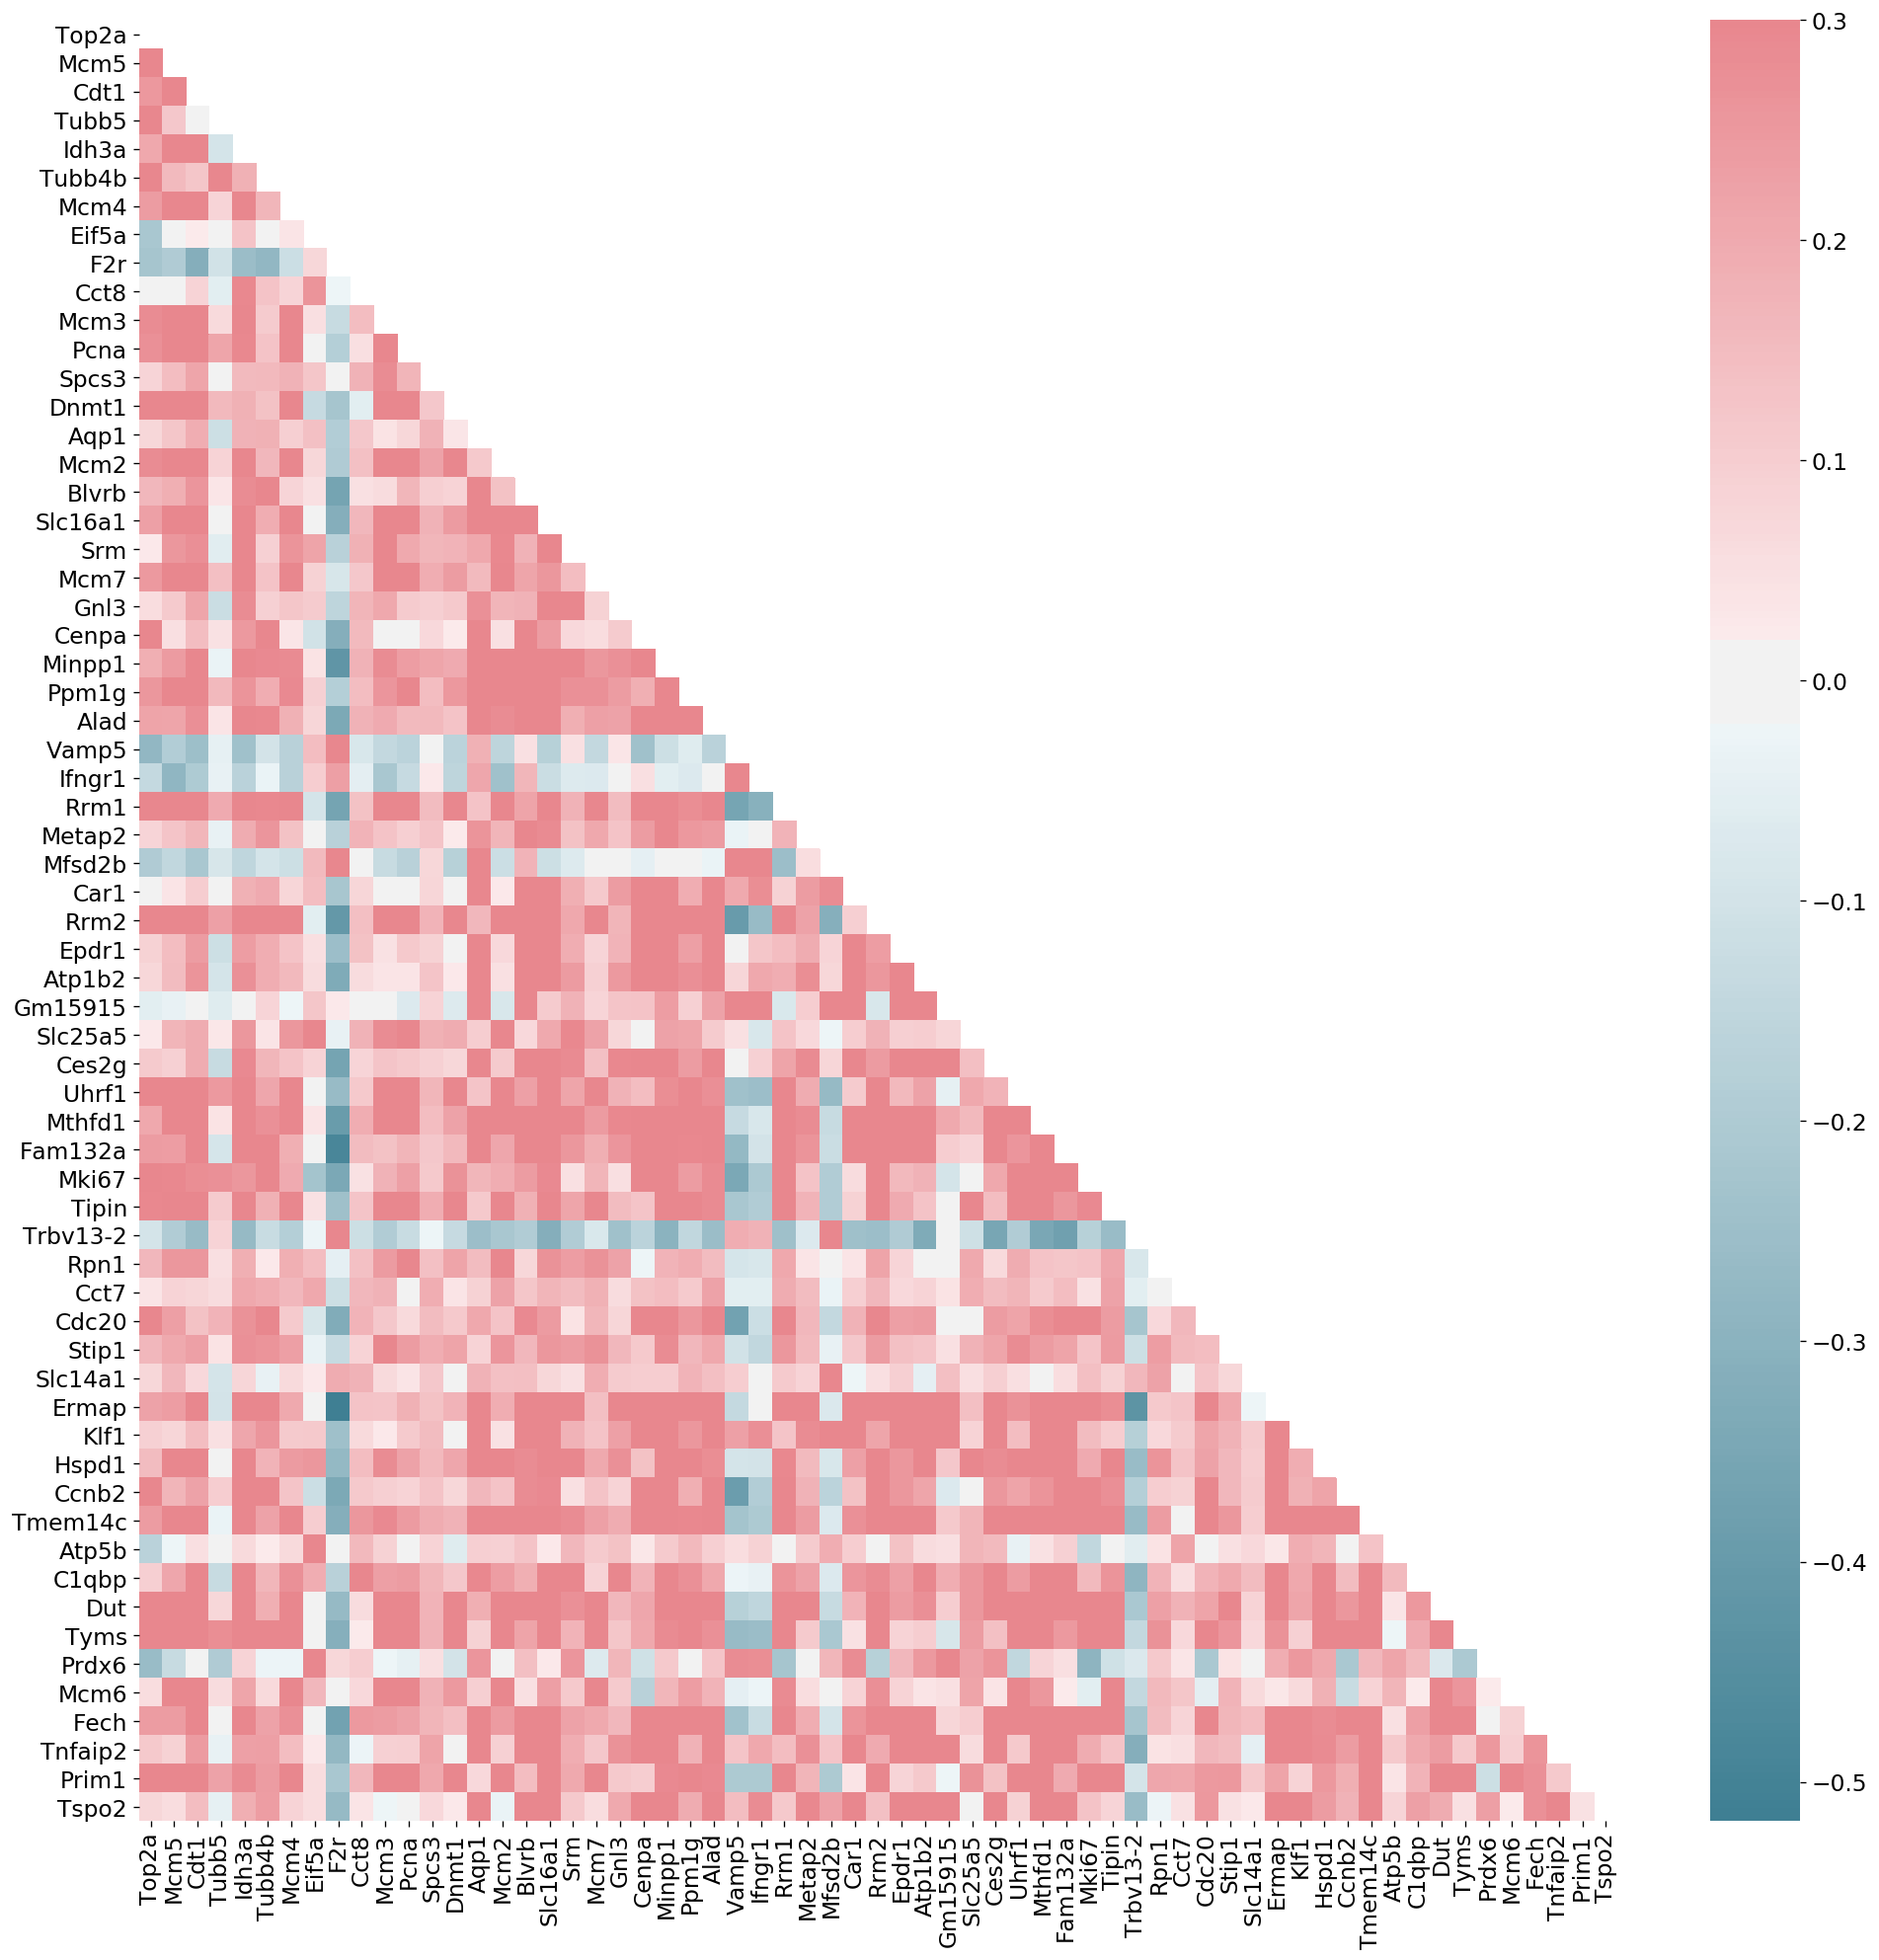

In [19]:
#gene correlation heatmap
gh.geneCorrelation(stream_gne, gene=set(stream_gne.NetAttrs['consensus'].source),
                cell_clusterid=('S2', 'S1'), select_by='branch_id_alias',
                order_by='S1_pseudotime', yticklabels=True, xticklabels=True, 
                save_as='result/gene_correlation.pdf', figsize=[20, 20])

In [20]:
# visualiza gene dynamics along pseudotime
# gh.geneDynamic(stream_gne, gene=set(stream_gne.NetAttrs['consensus'].source[1:20]),
#                 cell_clusterid="('S2', 'S1')", select_by='branch_id_alias', rolling=30,
#                 order_by='S2_pseudotime', save_as='result/gene_dynamic.pdf')

In [21]:
#save stream_gne as pickle 
# stream_gne.save_as('data/pyscnet_stream.pk')
# stream_gne = gnetdata.load_Gnetdata_object('data/pyscnet_stream.pk')